Donde entrenamos el modelo que liga a profesores de Grace con perfiles de MisProfes

In [1]:
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from misProfesScrapper import get_features
from utils import claveToDepto

os.makedirs("data/scrappers", exist_ok=True)

random_state = 42
np.random.seed(random_state)

In [4]:
# Load scrapper data

# misProfesUrl = "https://www.misprofesores.com/escuelas/ITAM-Instituto-Tecnologico-Autonomo-de-Mexico_1003"
# profesScrapper = MisProfesScrapper(misProfesUrl)
# profesScrapper.scrap()
# with open("data/scrappers/mis_profes.pkl", "wb") as f:
#     pickle.dump(profesScrapper, f)

# or load
profesScrapper = pickle.load(open("data/scrappers/mis_profes.pkl", "rb"))
print(len(profesScrapper.data))


# graceScrapper = GraceScrapper()
# graceScrapper.scrap()

# with open("data/scrappers/grace.pkl", "wb") as f:
#     pickle.dump(graceScrapper, f)

# or load
graceScrapper = pickle.load(open("data/scrappers/grace.pkl", "rb"))

id_to_info = {}
for info in profesScrapper.data.values():
    id_to_info[info['id']] = info
# id_to_info

1482


In [5]:
# Specific preprocessing for training / testing 
# Deployment will have different ways of constructing columns
# Note: final preprocessing will be done in the pipeline

df = pd.read_csv('data/labelled_matches.csv')

# Get id, name, and depto from MisProfes link
def add_mis_profes_info(row):

    if isinstance(row['Link MisProfes'], str):
        id = row['Link MisProfes'].split('_')[-1]
        nombre = id_to_info[id]['nombre']
        depto = id_to_info[id]['depto']
        n = id_to_info[id]['n']
    else:
        id, nombre, depto, n = None, None, None, None

    return pd.Series({
        'Id MisProfes': id,
        'Nombre MisProfes': nombre,
        'Depto MisProfes': depto,
        'no. de reviews': n
    })
df = pd.concat([df, df.apply(add_mis_profes_info, axis = 1)], axis = 1)

# Train on first 100, test on next 50
training_df = df.iloc[:100].copy()
test_df = df.iloc[100:150].copy()

def prep(df, k = 10, training = True):

    df = df.copy()

    if training: # keep only those that matched as positives
        df = df[~df['Id MisProfes'].isna()]
        df['Match'] = True
    else:
        df['Match'] = df['Id MisProfes'].notna()

    # For training, get negative examples by randomly sampling k other misProfes for every grace one
    negatives = []
    for _, row in df.iterrows():

        id = row['Id MisProfes']

        if training and (id is None or pd.isna(id)):
            continue
        
        neg_ids = list(id_to_info.keys())
        if id in neg_ids:
            neg_ids.remove(id)

        for neg_id in np.random.choice(neg_ids, k) if training else neg_ids:

            neg_row = row.copy()
            neg_row.update({
                'Id MisProfes': neg_id,
                'Link MisProfes': id_to_info[neg_id]['link'],
                'Nombre MisProfes': id_to_info[neg_id]['nombre'],
                'Depto MisProfes': id_to_info[neg_id]['depto'],
                'Match': False
            })
            negatives.append(neg_row)

    negatives = pd.DataFrame(negatives)
    df = pd.concat([df, negatives], ignore_index = True)

    # Extract deparments from claves de clases
    df['Deptos Grace'] = df['Claves Clases'].apply(lambda x: ','.join(set([claveToDepto[c.split('-')[0]] for c in x.split(', ')])))

    # Extract features
    df = pd.concat([df, get_features(df)], axis = 1)

    # shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


training_df = prep(training_df)
test_df = prep(test_df, training = False)

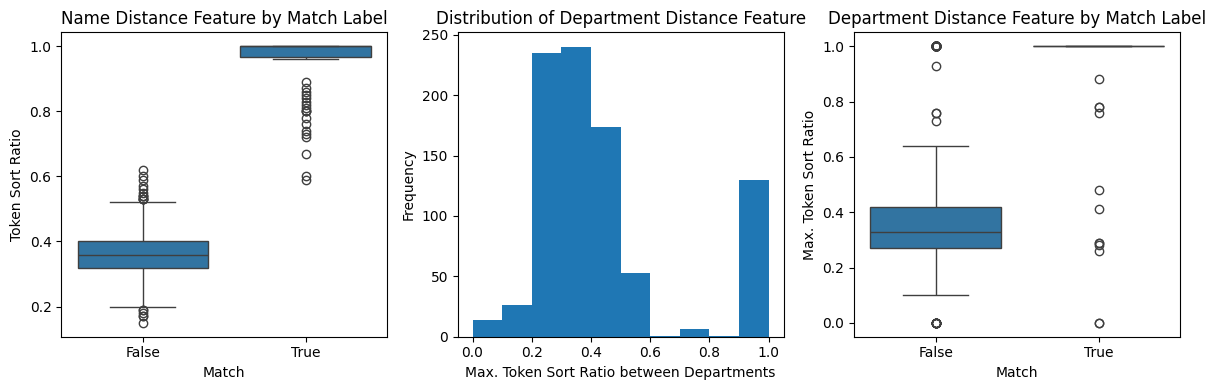

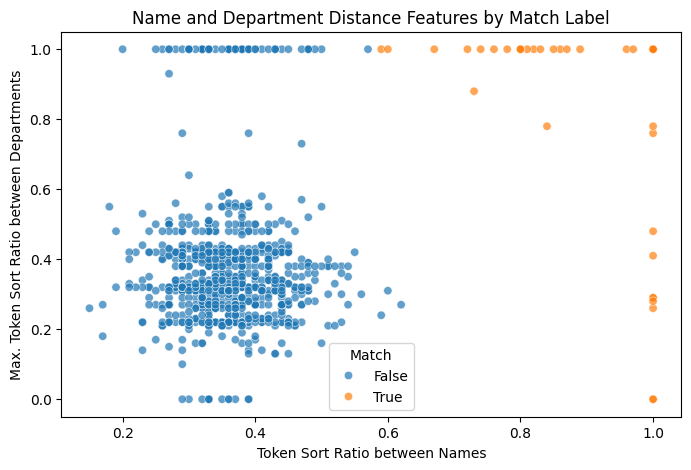

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax = ax1

sns.boxplot(data = training_df, x = 'Match', y = 'name_token_sort', ax=ax)
ax.set_ylabel('Token Sort Ratio')
ax.set_title('Name Distance Feature by Match Label')

ax = ax2
ax.hist(training_df['dept_max_ratio'])

ax.set_title('Distribution of Department Distance Feature')
ax.set_xlabel('Max. Token Sort Ratio between Departments')
ax.set_ylabel('Frequency')
ax = ax3
sns.boxplot(data = training_df, x = 'Match', y = 'dept_max_ratio', ax=ax)
ax.set_ylabel('Max. Token Sort Ratio')
ax.set_title('Department Distance Feature by Match Label')

plt.tight_layout()

plt.figure(figsize=(8, 5))
sns.scatterplot(data = training_df, x = 'name_token_sort', y = 'dept_max_ratio', hue = 'Match', alpha=0.7)
plt.title('Name and Department Distance Features by Match Label')
plt.ylabel('Max. Token Sort Ratio between Departments')
plt.xlabel('Token Sort Ratio between Names')
plt.savefig('feature_scatter.png', dpi=300)

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('custom', FunctionTransformer(get_features)),
    ('clf', LogisticRegression(random_state = random_state)),
], memory = './cache')


cv_results = cross_validate(pipeline, X = training_df, y = training_df['Match'], cv = 5, scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
{k: float(v.mean()) for k, v in cv_results.items() if 'test' in k}

{'test_accuracy': 0.9886363636363636,
 'test_roc_auc': 1.0,
 'test_precision': 1.0,
 'test_recall': 0.875,
 'test_f1': 0.9314285714285715}

In [9]:
pipeline.fit(training_df, training_df['Match'])
print(pipeline.named_steps['clf'].coef_)

preds = pipeline.predict(test_df)
preds_prob = pipeline.predict_proba(test_df)[:, 1]

# print metrics
y_test = test_df['Match']
print("F1 Score:", f1_score(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, preds_prob))
print("Precision:", precision_score(y_test, preds))

# save clf w pickle
with open('match_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

[[7.54813972 3.02377667]]
F1 Score: 0.8571428571428571
Accuracy: 0.9998380807167627
ROC AUC: 0.9999707491809771
Precision: 0.8


In [ ]:
def match_a(test_df, clf, threshold = 0.5):

    out = []

    # Predice pareja de cada profesor de Grace
    for nombre_grace in test_df['Nombre Grace'].unique():

        _df = test_df[test_df['Nombre Grace'] == nombre_grace]
        
        has_match = _df['Match'].sum() > 0
        true_match_id = _df[_df['Match']]['Id MisProfes'].values[0] if has_match else None

        preds = clf.predict_proba(_df)[:, 1]

        pred_match_id = None
        if preds.max() > threshold:
            pred_match_id = _df.iloc[np.argmax(preds)]['Id MisProfes']
        
        out.append({
            'Nombre Grace': nombre_grace,
            'Id MisProfes': pred_match_id,
            'max prob': preds.max(), # if pred_match_id else None,
            # TMP
            'token_sort_ratio': _df.iloc[np.argmax(preds)]['name_token_sort'],
            'max dept ratio': _df.iloc[np.argmax(preds)]['dept_max_ratio'],
            'name argmax': _df.iloc[np.argmax(preds)]['Nombre MisProfes'],
            'Nombre MisProfes': _df[_df['Id MisProfes'] == pred_match_id]['Nombre MisProfes'].values[0] if pred_match_id else None,

            'Correct': pred_match_id == true_match_id,
            'Incorrect Match': pred_match_id is not None and pred_match_id != true_match_id,
            'Incorrect No Match': pred_match_id is None and pred_match_id != true_match_id,
        })


    return pd.DataFrame(out)

res = match_a(test_df, pipeline, threshold = 0.5)

res['Correct'].mean(), res['Incorrect Match'].mean(), res['Incorrect No Match'].mean(), res['Id MisProfes'].notna().mean()

In [18]:
# perform cross validation on pipeline split + match_a

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

# hyper params -> metric -> list of n_splits values 
# cv_results = defaultdict(lambda: defaultdict(list))
cv_results = []

for train_index, test_index in kf.split(df.iloc[:100]):

    for k in [1, 5, 10, 100]:

        training_df_k = prep(df.iloc[train_index], k = k)
        test_df_k = prep(df.iloc[test_index], training=False)

        pipeline.fit(training_df_k, training_df_k['Match'])

        results = cv_results

        for threshold in [0.25, 0.5, 0.75, 0.9, 0.95]:

            res = match_a(test_df_k, pipeline, threshold = threshold)

            cv_results.append({
                'k': k,
                'threshold': threshold,
                'correct': res['Correct'].mean(),
                'incorrect_match': res['Incorrect Match'].mean(),
                'incorrect_no_match': res['Incorrect No Match'].mean(),
                'has_match': res['Id MisProfes'].notna().mean()
            })

cv_results = pd.DataFrame(cv_results)

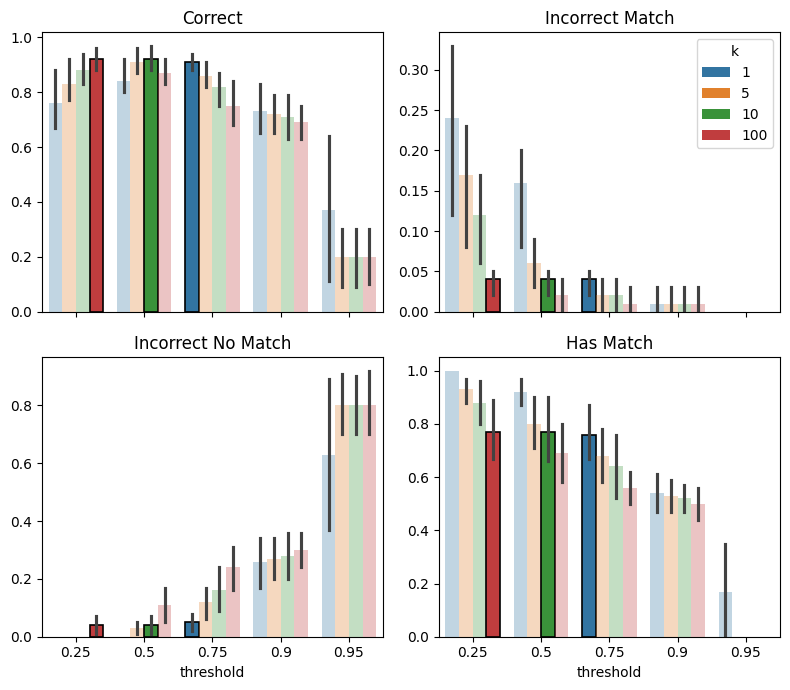

In [ ]:
cv_results = pd.read_csv('cv_results.csv')

f, axs = plt.subplots(2, 2, figsize=(8, 7), sharex=True)

ks = sorted(cv_results['k'].unique())
thresholds = sorted(cv_results['threshold'].unique())

# param settings to highlight
highlight = {(0.25, 100), (0.5, 10), (0.75, 1)}

for ax, c in zip(axs.flatten(), ['correct', 'incorrect_match', 'incorrect_no_match', 'has_match']):
    ax.set_title(c.replace('_', ' ').title())

    g = sns.barplot(
        cv_results, x='threshold', y=c, hue='k',
        palette='tab10', ax=ax, hue_order=ks
    )
    ax.set_ylabel('')

    # Iterate through bar containers (one per hue=k)
    for k_val, container in zip(ks, ax.containers):
        for bar, t_val in zip(container, thresholds):
            if (t_val, k_val) not in highlight:
                bar.set_alpha(0.3)
            else:
                bar.set_alpha(1.0)
                bar.set_edgecolor("black")
                bar.set_linewidth(1.2)

    if ax != axs[0, 1]:
        ax.get_legend().remove()

plt.tight_layout()
plt.savefig('cv_results.png', dpi=300)

In [7]:
def baseline_old_method(test_df, threshold = 0.5):

    out = []

    # Predice pareja de cada profesor de Grace
    for nombre_grace in test_df['Nombre Grace'].unique():

        _df = test_df[test_df['Nombre Grace'] == nombre_grace]
        
        has_match = _df['Match'].sum() > 0
        true_match_id = _df[_df['Match']]['Id MisProfes'].values[0] if has_match else None

        pred_match_id = None
        pred_match_nombre = None
        for i, row in _df.iterrows():
            if row['name_lev_ratio'] > threshold:
                pred_match_id = row['Id MisProfes']
                pred_match_nombre = row['Nombre MisProfes']
                break
        
        out.append({
            'Nombre Grace': nombre_grace,
            'Id MisProfes': pred_match_id,
            # 'max prob': preds.max(), # if pred_match_id else None,
            # TMP
            # 'token_sort_ratio': _df.iloc[np.argmax(preds)]['name_token_sort'],
            # 'max dept ratio': _df.iloc[np.argmax(preds)]['dept_max_ratio'],
            # 'name argmax': _df.iloc[np.argmax(preds)]['Nombre MisProfes'],
            'Nombre MisProfes': pred_match_nombre,

            'Correct': pred_match_id == true_match_id,
            'Incorrect Match': pred_match_id is not None and pred_match_id != true_match_id,
            'Incorrect No Match': pred_match_id is None and pred_match_id != true_match_id,
        })


    return pd.DataFrame(out)

res = baseline_old_method(test_df, threshold = 0.95)

res['Correct'].mean(), res['Incorrect Match'].mean(), res['Incorrect No Match'].mean(), res['Id MisProfes'].notna().mean()

(0.82, 0.04, 0.14, 0.66)

In [19]:
import json
# datos_profes = json.load(open('../tmp.json', 'r'))['profesores']
datos_profes = json.load(open('../tmp.json', 'r'))

# nombre grace -> misProfes id
matches_deployed = {nombre: info['link'].split('_')[-1] if 'link' in info else None for nombre, info in datos_profes.items()}
len(matches_deployed)

matches_local = dict(zip(res['Nombre Grace'], res['Id MisProfes']))

In [20]:
diffs = 0
total = 0
for nombre, match_id in matches_deployed.items():
    if nombre not in matches_local: continue
    if match_id != matches_local[nombre]:
        print(nombre, matches_local[nombre], match_id,datos_profes[nombre])
    diffs += match_id != matches_local[nombre]
    total += 1

diffs, len(matches_deployed), len(matches_local), total

(0, 333, 50, 37)